# Clustering
My goal is to put a point on the map where the cyclone centre probably is \
My general idea is to iterate through the dataset doing K-means with K=1, for obvious reasons, including a bias for higher magnitudes 

I simply need to do a maximisation step, as the expectation will always yield the one and only cluster assignment.

The following is the unmodified K-means M-step.
$$
\begin{equation}
    \bold{\mu}_k = \frac{\sum_nr_{nk}\bold{x}_n}{\sum_n r_{nk}}
\end{equation}
$$

the $\sum_n r_{nk}$ indicates that we are excluding any values not in the cluster. When there is only one cluster, they are all assigned to it, so this will be effectively mulitplying every value by 1. So in the special case of K=1, the following holds

$$
\mu_k = \frac{\sum_n\bold{x}_n}{n}
$$

Next I will add in a bias term for the magnitudes of each point. This takes the form of $f(\bold{x}_n)$ which acts as a responsibility of the point on the resulting mean. To cancel out the bias when calculating the mean, we must divide by the whole responsibility of the dataset. 

In order to exacerbate the difference between the low values and high ones, I introduce an order, $ \alpha $ on to the responsibility. This will make the low values insignificant compared to the high values at the centre of the cyclone. 

$$
\mu_k = \frac{\sum_n f(\bold{x}_n)^\alpha \bold{x}_n}{\sum_n f(\bold{x}_n)^\alpha}
$$


In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import imageio
import os

In [2]:
PATH = "../data/1991TS"
# WIND SPEED OF GUST
FG = "fg.T1Hmax.UMRA2T.19910428_19910501.BOB01.4p4km.nc"

fg = nc.Dataset(f"{PATH}/{FG}")

In [5]:
latitude = fg.variables["latitude"][:]
longitude = fg.variables["longitude"][:]
wind_speed = fg.variables["wind_speed_of_gust"][:][0]

# a single frame
var_frame = wind_speed[0]

## Implementation

In [4]:
def mag_m_step(frame: np.array, long: np.array, lat: np.array):
    # The sum of responsibilities in the denominator
    sum_resp = 0
    # weighted points, the numerator
    xs = [0, 0]
    # The order put on the responsibility
    alpha = 4
    
    for x in range(len(lat)):
        for y in range(len(long)):
            if x < frame.shape[0] and y < frame.shape[1]:
                fn = frame[x][y]
                xs += np.multiply([long[y], lat[x]], fn**alpha)
                
                sum_resp += fn**alpha
            
    return np.divide(xs, sum_resp)

### Optimised
Written in final development cycle for optimal performance on compute cluster.

In [ ]:
def mag_m_step(frame: np.array, lng: np.array, lat: np.array):
    assert frame.shape == (len(lat), len(lng))
    # The sum of responsibilities in the denominator
    sum_resp = 0
    # weighted points, the numerator
    xs = [0, 0]
    # The order put on the responsibility
    alpha = 4
    
    for lt, row in zip(lat, frame):
        for lg, val in zip(lng, row):
            inc = val ** alpha
            xs[0] += lt * inc
            xs[1] += lg * inc
            
            sum_resp += inc
            
    return np.divide(xs, sum_resp)

## Results
I am expecting the centroid to be around: `(86.5, 16)`

In [6]:
centroid = mag_m_step(var_frame, longitude, latitude)

print(f"Predicted Centroid: {centroid}")

Predicted Centroid: [88.05996026 17.69579605]


In [7]:
centroids = [mag_m_step(frame, longitude, latitude) for frame in wind_speed]

In [5]:
def visualise(output_filename: str, long: np.ndarray, lat: np.ndarray, variable: np.ndarray, centroids=None):
    """
    just a bog standard visualisation function for putting a time series variable on a long vs lat graph
    variable should be a time series of frames
    """
    filenames = []
    maxlevel = variable.max()
    minlevel = variable.min()
    steps = 7
    levels = [((maxlevel - minlevel)/steps) * val for val in list(range(steps))]
    
    for idx, frame in enumerate(variable):
        fig, ax = plt.subplots()
        cntr = ax.contourf(long, lat, frame, levels=levels)
        fig.colorbar(cntr, ax=ax)
        if centroids:
            ax.plot(centroids[idx][0], centroids[idx][1], "ro")
        filename = f"vis/sc{idx}.png"
        filenames.append(filename)
        plt.savefig(filename)
        plt.close()
        
    # build gif
    with imageio.get_writer(f"vis/{output_filename}", mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
            
    # Remove files
    for filename in set(filenames):
        os.remove(filename)
        


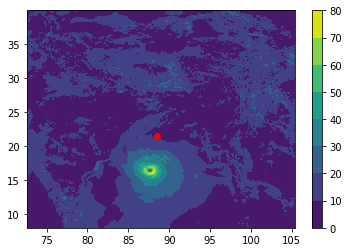

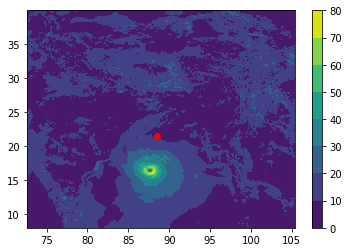

In [ ]:
# plot graph
fig, ax = plt.subplots()
cntr = ax.contourf(longitude, latitude, var_frame)
fig.colorbar(cntr, ax=ax)

# plot centroid
ax.plot(centroid[0], centroid[1], "ro")

plt.show()# plot graph
fig, ax = plt.subplots()
cntr = ax.contourf(longitude, latitude, var_frame)
fig.colorbar(cntr, ax=ax)

# plot centroid
ax.plot(centroid[0], centroid[1], "ro")

plt.show()

In [ ]:
visualise("centroids.gif", longitude, latitude, wind_speed)

![Centroids](./vis/centroids.gif)

## Threshold

There is a bias northward when the noise increases in that direction. Seeing as there is a significant difference between the cyclone and the noise, I can significantly threshold. I will threshold at 50% of the maximum value

In [8]:
maximum = wind_speed.max()
thresh_wind = np.array([np.where(frame < maximum * .3, 0, frame)for frame in wind_speed ])

# thresh_centroids = [mag_m_step(frame, longitude, latitude) for frame in thresh_wind]

In [9]:
visualise("threshold.gif", longitude, latitude, thresh_wind)

In [ ]:
visualise("threshold.gif", longitude, latitude, thresh_wind, centroids=thresh_centroids)

![Centroids](./vis/threshold.gif?arg) ![Centroids](./vis/centroid_threshold.gif?arg)

In [42]:
below_wind = np.array(
    [[np.where(frame < wind_speed.max() * .3, frame, np.nan) for frame in ensemble ] for ensemble in wind_speed ])

below_wind.shape

(48, 9, 790, 810)

In [49]:
matrix = np.array([[2,1,2], 
          [-1, -2, -3], 
          [1, -1, 1]]) 
np.where(matrix > 0, 1, 0)

array([[1, 1, 1],
       [0, 0, 0],
       [1, 0, 1]])

In [57]:
clouds = np.array([[np.where(stats.zscore(frame, nan_policy="omit") > -1, frame, np.nan) for frame in ensemble] for ensemble in below_wind])

In [64]:
print(np.nanmax(clouds), np.nanmin(clouds))
print(np.nanmax(below_wind), np.nanmin(below_wind))

29.75 1.375
29.75 0.375


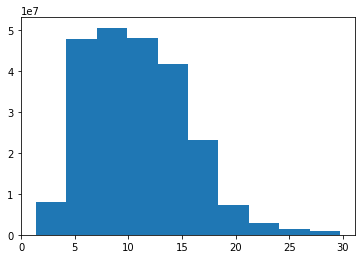

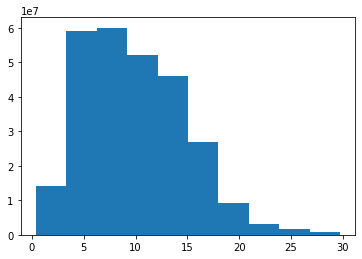

In [58]:
plt.hist(clouds.flatten())
plt.show()
plt.hist(below_wind.flatten())
plt.show()

In [32]:
flat = below_wind[0][0].flatten()
flat = flat[~np.isnan(flat)]

In [16]:
from scipy import stats

In [38]:
zscore = stats.zscore(flat)
scored = flat[zscore > -1]

In [39]:
print (flat.max(), flat.min())
print (scored.max(), scored.min())

29.75 0.75
29.75 4.75


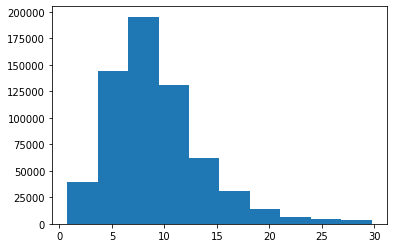

<function matplotlib.pyplot.show(close=None, block=None)>

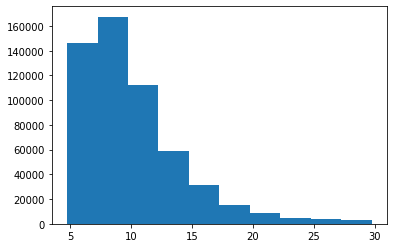

In [41]:
plt.hist(flat)
plt.show()
plt.hist(scored)
plt.show

In [67]:
[[1, 1, 1, n/4] for n in range(4)]

[[1, 1, 1, 0.0], [1, 1, 1, 0.25], [1, 1, 1, 0.5], [1, 1, 1, 0.75]]